# Quantum adders and quantum multipliers

---
Modular sum by classical $b$
---

Our first task is to compose a circuit that performs 

$$\left|a\right\rangle \mapsto  \left|a+b\right\rangle$$

for a fixed $b$.

The approach we will take is by using the quantum discrete transformation. First, we initalize our system to the state $\left|a\right\rangle$. After applying DFT to this state, we are left with

$$
DFT\left|a\right\rangle =\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{\frac{2\pi iak}{N}}\left|k\right\rangle
$$ 

Now, consider the unitary operator

$$
U_b \left|k\right\rangle = e^{2\pi i b \frac{k}{N}} \left|k\right\rangle
$$

If we apply it to $ DFT\left|a\right\rangle$, we get

$$
U_b DFT\left|a\right\rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{\frac{2\pi i(a+b)k}{N}}\left|k\right\rangle
$$ 

Therefore, by applying the inverse DFT operator to the previous state, we get

$$
DFT^{-1}U_bDFT\left|a\right\rangle = \left|a+b\right\rangle
$$

We already know how to implement the DFT operator (and it's inverse). To implement the $U_b$ operator, we just need to apply the phase operator P with angle $2^k 2 \pi /N b$ to the $k$-th qubit. 

Note that if we perform the operations in reverse order, we get subtraction:

$$
DFT^{-1}U^{-1}_b DFT \left|a+b\right\rangle= \left|a\right\rangle .
$$

Also, the adition is $modN$, that is, $a+b = (a+b)modN$

Let us write an implementation for $U_{b}$ using the phase gate

$$
P\left(\lambda\right)=\left(\begin{array}{cc}
1 & 0\\
0 & e^{i\lambda}
\end{array}\right)
$$ 

Consider the operator

$$
U=P\left(\lambda_{n-1}\right)\otimes P\left(\lambda_{n-2}\right)\otimes\cdots\otimes P\left(\lambda_{0}\right)
$$

acting on $\left|k\right\rangle =\left|k_{n}k_{n-1}\cdots k_{0}\right\rangle$,
where $k=k_{0}2^{0}+k_{1}2^{1}+\cdots+k_{n-1}2^{n-1}$ is the $n$-bit
binary representation for $k$. The angles are given by

$$
\lambda_{i}=\frac{2^{i+1}\pi b}{2^{n}}
$$ 

where $b$ is fixed. Then,

$$
U\left|k\right\rangle =P\left(\lambda_{n-1}\right)\left|k_{n-1}\right\rangle \otimes P\left(\lambda_{n-2}\right)\left|k_{n-2}\right\rangle \otimes\cdots\otimes P\left(\lambda_{0}\right)\left|k_{0}\right\rangle \,.
$$

Since

$$
P\left(\lambda_{i}\right)\left|k_{i}\right\rangle =e^{i\lambda_{i}k_{i}}\left|k_{i}\right\rangle ,\,\,k_{i}\in\left\{ 0,1\right\} \,,
$$

we get

$$
U\left|k\right\rangle =\Pi_{i=0}^{n-1}e^{i\lambda_{i}k_{i}}\left|k\right\rangle =e^{i\sum_{i=0}^{n-1}\lambda_{i}k_{i}}\left|k\right\rangle
$$

Finally, by noting that

$$
\sum_{i=0}^{n-1}\lambda_{i}k_{i}=\sum_{i=0}^{n-1}\frac{2^{i+1}\pi b}{2^{n}}k_{i}=\frac{2\pi b}{2^{n}}\sum_{i=0}^{n-1}2^{i}k_{i}=\frac{2\pi b}{2^{n}}k
$$

we arrive at $U=U_{b}$.

In [1]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation
import numpy as np
def dft(n):
    dftcirc = QuantumCircuit(n)
    #make the rotations
    for k in range(n-1,-1,-1):
        dftcirc.h(k)
        p=2
        for l in range(k-1,-1,-1):
            dftcirc.cp(2*np.pi/2**p,l,k)
            p+=1
       # dftcirc.barrier()
    #now we make the swap operations
    for qubit in range(n//2):
        dftcirc.swap(qubit, n-qubit-1)
    return dftcirc

#below N=2**n such that a<N
# if a+b >= 2**n, then circuit calculates (a+b)modN
def modular_sum(a,b,n):
    if a>=2**n:
        raise Exception('a >= N=2**n')
    else:
        qbits = QuantumRegister(n)
        cbits = ClassicalRegister(n)
        modsumqc = QuantumCircuit(qbits,cbits)
        #initialize state |a>
        astate = Statevector.from_int(a,2**n)
        modsumqc.initialize(astate,qbits)
        modsumqc.append(dft(n),qbits)
        #now we implement the unitary U_b
        for i in range(n):
            modsumqc.p(2**(i+1)*np.pi*b/2**n,i)
        modsumqc.append(dft(n).inverse(),qbits)
        #modsumqc.measure(qbits,cbits)
        return modsumqc

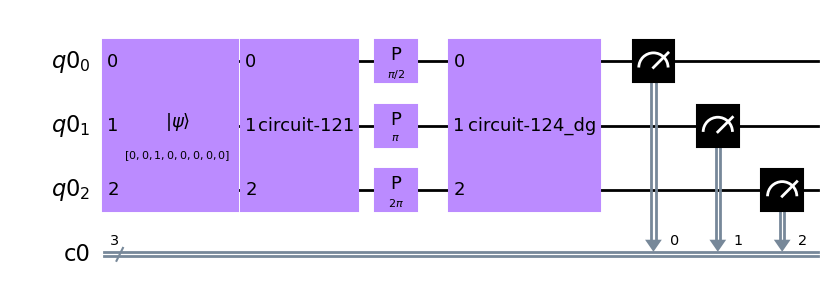

In [2]:
qc = modular_sum(2,2,3)
qc.measure([0,1,2],[0,1,2])
qc.draw(output="mpl")

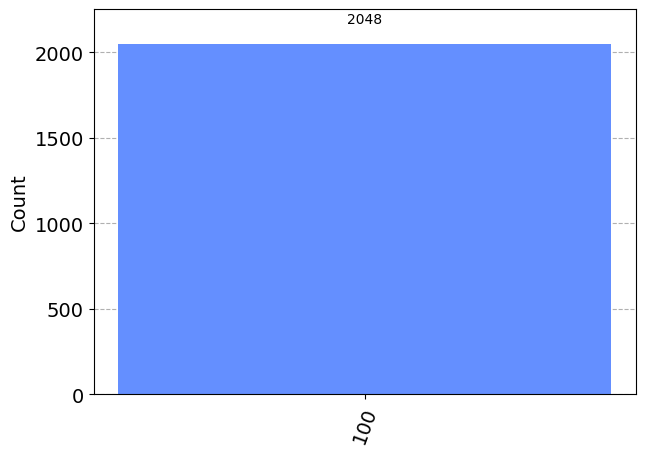

In [3]:
#run circuit simulator
from qiskit import Aer,transpile
from qiskit.visualization import plot_histogram

aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_modsum = transpile(qc, aer_sim)
results = aer_sim.run(t_modsum, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

---
Multiplication by classical $b$
---

Now that we know how to sum $(a+b)modN$, let us see how to multiply $a\mapsto ab$, that is, we need a unitary operator $U_b$ such that $U_b \left|a\right\rangle = \left|ab\right\rangle$.
There’s a simple algorithm which does this in time $O(b)$: simply add $a$ to your register $b$  times. One can do modular_sum(a,(b-1)*a,n)  to obtain a*b(mod2**n) from the above.

In [4]:
b=3
a=2
qc = modular_sum(a,(b-1)*a,2)
qc.measure([0,1],[0,1])

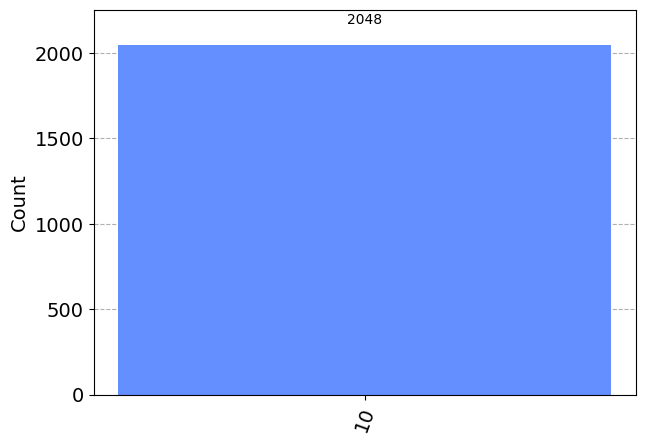

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_modsum = transpile(qc, aer_sim)
results = aer_sim.run(t_modsum, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

---
Quantum addition
---

This is very similar to the previous section where we perform a modular
sum by a classical $b$, that is, we perform
$\left|a\right\rangle \mapsto\left|a+b\,\,\,(modN)\right\rangle$, but
now we sum two quantum registers
$\left|a\right\rangle \left|b\right\rangle \mapsto\left|a\right\rangle \left|a+b\,\,(modN)\right\rangle$.
The general idea is the same, we start by applying the DFT operator to
the target register $\left|b\right\rangle$:

$$
\left|a\right\rangle \left|b\right\rangle \mapsto\left|a\right\rangle DFT\left|b\right\rangle
$$

Then we apply a unitary $U$ on
$\left|a\right\rangle \otimes DFT\left|b\right\rangle$ such that

$$
U\left(\left|a\right\rangle DFT\left|b\right\rangle \right)=\left|a\right\rangle \otimes\left(\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{\frac{2\pi i\left(a+b\right)k}{N}}\left|k\right\rangle \right)
$$

Then it is a matter of applying the inverse $DFT$ to the second register
to obtain

$$
\left(I\otimes DFT^{-1}\right)U\left(\left|a\right\rangle DFT\left|b\right\rangle \right)=\left|a\right\rangle \left|a+b\,\,(modN)\right\rangle
$$

Therefore, our task is to understand how the unitary $U$ works. The idea
is to use our previous result, but since now we are summing two quantum
registers, the phase operators acting on the target register must be
conditioned by the source register. We can do this by inspection. Start
with $\left|a\right\rangle DFT\left|b\right\rangle$:

$$
\left|a\right\rangle DFT\left|b\right\rangle =\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{\frac{2\pi ibk}{N}}\left|a\right\rangle \left|k\right\rangle
$$

Now we must have 

$$
\begin{aligned}
U\left(\left|a\right\rangle \left|k\right\rangle \right) & =e^{\frac{2\pi iak}{N}}\left|a\right\rangle \left|k\right\rangle \\
 & =\prod_{l,j=0}^{N-1}\exp\left(\frac{2\pi i}{N}2^{j+l}a_{j}k_{l}\right)\left|a_{N-1}\cdots a_{0}\right\rangle \left|k_{N-1}\cdots k_{0}\right\rangle \,,\end{aligned}$$

where $a_{j},k_{l}\in\left\{ 0,1\right\}$ are the coeficients of the
binary expansions of the integers $a$ and $b$. In order to get the
desired result, we can apply controlled phase operators. We target each
$\left|k_{l}\right\rangle$ with phase operators
$P\left(\lambda_{jl}\right)$, $\lambda_{jl}=\frac{2\pi i}{N}2^{j+l}$,
controlled by each one of the $\left|a_{j}\right\rangle$. We take
advantage of the fact that $k_{l},a_{j}\in\left\{ 0,1\right\}$, to write

$$
U_{jl}=\left|0\right\rangle \left\langle 0\right|\otimes I+\left|1\right\rangle \left\langle 1\right|\otimes P\left(\lambda_{jl}\right)
$$

so that 

$$
\begin{aligned}
U_{jl}\left(\left|a_{j}\right\rangle \left|k_{l}\right\rangle \right) & =\left\langle 0\right|\left.a_{j}\right\rangle \left|0\right\rangle \left|k_{l}\right\rangle +\left\langle 1\right|\left.a_{j}\right\rangle \left|1\right\rangle P\left(\lambda_{jl}\right)\left|k_{l}\right\rangle \\
 & =\left\langle 0\right|\left.a_{j}\right\rangle \left|0\right\rangle \left|k_{l}\right\rangle +\left\langle 1\right|\left.a_{j}\right\rangle \left|1\right\rangle e^{i\lambda_{jl}k_{l}}\left|k_{l}\right\rangle \\
 & =\left(\left\langle 0\right|\left.a_{j}\right\rangle \left|0\right\rangle +\left\langle 1\right|\left.a_{j}\right\rangle \left|1\right\rangle \right)e^{i\lambda_{jl}k_{l}a_{j}}\left|k_{l}\right\rangle \\
 & =e^{i\lambda_{jl}k_{l}a_{j}}\left|a_{j}\right\rangle \left|k_{l}\right\rangle \end{aligned}
$$

By composing over the contribuitions of $U_{jl}$ for each $j$,
$U_{l}=U_{0l}\circ U_{1l}\circ\cdots\circ U_{N-1,l}$, we get

$$
U_{l}\left(\left|a\right\rangle \left|k_{l}\right\rangle \right)=e^{i\sum_{j}\lambda_{jl}a_{j}k_{l}}\left|a\right\rangle \left|k_{l}\right\rangle
$$

Finally, by applying $U_{l}$ for all $l$, we get

$$
U\left(\left|a\right\rangle \left|k\right\rangle \right)=\prod_{l,j=0}^{N-1}\exp\left(\frac{2\pi i}{N}2^{j+l}a_{j}k_{l}\right)\left|a\right\rangle \left|k\right\rangle \,.
$$

In [6]:
#perform |a>|b> -->  |a>|a+b (modN)>

def modular_qsum(a,b,n):
    if a>=2**n or b>=2**n:
        raise Exception('a >= 2**n or b>=2**n')
    else:
        q1bits = QuantumRegister(n)
        q2bits = QuantumRegister(n)
        #cbits = ClassicalRegister(n)
        modsumqc = QuantumCircuit(q1bits,q2bits)
        #initialize state |a>
        #use StatePreparation so that circuit can be converted to gate
        astate = StatePreparation(a,n)
        #astate = Statevector.from_int(a,2**n)
        #modsumqc.initialize(astate,q1bits)
        modsumqc.append(astate,q1bits)
        #initialize state |b>
        bstate = StatePreparation(b,n)
        modsumqc.append(bstate,q2bits)
        #bstate = Statevector.from_int(b,2**n)
        #modsumqc.initialize(bstate,q2bits)
        #apply DFT to |b>
        modsumqc.append(dft(n).to_gate(),q2bits)
        #now we implement the unitary U
        for i in range(n):
            for j in range(n):
                modsumqc.cp(2**(i+j+1)*np.pi/2**n,q1bits[j],q2bits[i])
            #modsumqc.barrier()
        modsumqc.append(dft(n).inverse().to_gate(),q2bits)
        #modsumqc.measure(q2bits,cbits)
        return modsumqc

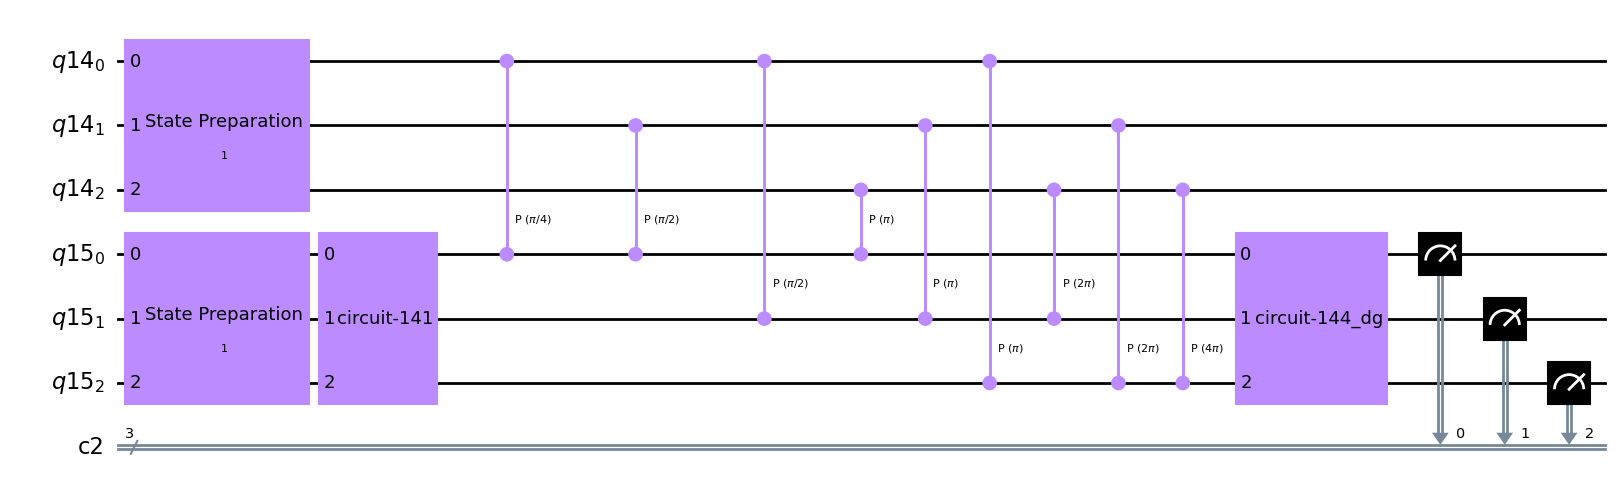

In [7]:
qc = modular_qsum(1,1,3)
cbits = ClassicalRegister(3)
qc.add_register(cbits)
qc.measure([3,4,5],[0,1,2])
qc.draw(output="mpl")

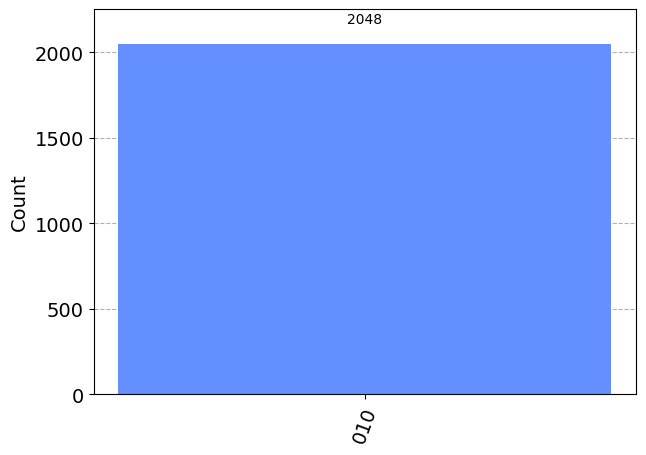

In [8]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_modsum = transpile(qc, aer_sim)
results = aer_sim.run(t_modsum, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

---
Quantum Multiplication
---

In this section our task is two write an algorithm which performs, given
two integers $a$ and $b$, the operation

$$
\left|a\right\rangle \left|b\right\rangle \mapsto\left|a\right\rangle \left|ab\right\rangle
$$

where $N=2^{n}$ and $\left|a\right\rangle$ and $\left|b\right\rangle$
are two $n$-qubit quantum registers. Let us start with $2$
$n$-qubit registers $\left|a\right\rangle$ and $\left|b\right\rangle$,
and one $2n$-qubit auxilliary register $\left|anc\right\rangle$ which
will record the sum. We write the the initial state of our system as

$$
\left|0\right\rangle ^{\otimes2n}\left|a\right\rangle \left|b\right\rangle \,,
$$

that is $\left|anc\right\rangle =\left|0\right\rangle ^{\otimes2n}$.
Start by applying DFT to $\left|anc\right\rangle$:

$$
\left|0\right\rangle ^{\otimes2n}\left|a\right\rangle \left|b\right\rangle \mapsto\frac{1}{\sqrt{2^{2n}}}\sum_{k=0}^{2^{2n}-1}\left|k\right\rangle \left|a\right\rangle \left|b\right\rangle
$$

We need to apply unitary operations to the last state so that in the end
we have

$$
\frac{1}{\sqrt{2^{2n}}}\sum_{k=0}^{2^{2n}-1}\left|k\right\rangle \left|a\right\rangle \left|b\right\rangle \mapsto\frac{1}{\sqrt{2^{2n}}}\sum_{k=0}^{2^{2n}-1}\exp\left(\frac{2\pi i\left(ab\right)k}{2^{2n}}\right)\left|k\right\rangle \left|a\right\rangle \left|b\right\rangle
$$

Let us start from the last state and decompose $a$ and $b$ in their
binary expansions,

$$
\frac{1}{\sqrt{2^{2n}}}\sum_{k=0}^{2^{2n}-1}\exp\left(\frac{2\pi i\sum_{r,s=0}^{2^{n}-1}\sum_{l=0}^{2^{2n}-1}2^{r+s+l}a_{r}b_{s}k_{l}}{2^{2n}}\right)\left|k\right\rangle \left|a\right\rangle \left|b\right\rangle =\frac{1}{\sqrt{2^{2n}}}\sum_{k=0}^{2^{2n}-1}\prod_{r,s=0}^{2^{n}-1}\prod_{l=0}^{2^{2n}-1}\exp\left(\frac{2\pi i2^{r+s+l}a_{r}b_{s}k_{l}}{2^{2n}}\right)\left|k\right\rangle \left|a\right\rangle \left|b\right\rangle 
$$

Each exponential can be seen as the result of applying a phase operator
$P\left(\lambda_{rsl}\right)$ to the qubit $k_{l}$ controlled by the
qubits $a_{r}$ and $b_{s}$, where
$\lambda_{rsl}=\frac{2\pi i2^{r+s+l}}{2^{2n}}$.

Note that for $a<2^n$  and $b<2^n$ we get $ab < 2^{2n}$. This is why the auxilliary register has $2n$ qubits, so that it can register $ab$ exactly.

In [9]:
# now we perform |a>|b> -> |ab>

from qiskit.circuit.library import PhaseGate

def modular_qmult(a,b):
    #determine circuit size
    n = int(np.ceil(max(np.log2(a),np.log2(b))))+1
    abits = QuantumRegister(n)
    bbits = QuantumRegister(n)
    ancilla = QuantumRegister(2*n)
    multqc = QuantumCircuit(abits,bbits,ancilla)
    #initialize state |a>
    astate = Statevector.from_int(a,2**n)
    multqc.initialize(astate,abits)
    #initialize state |b>
    bstate = Statevector.from_int(b,2**n)
    multqc.initialize(bstate,bbits)
    #apply DFT to |ancilla>
    multqc.append(dft(2*n),ancilla)
    for i in range(2*n):
        for r in range(n):
            for s in range(n):
                angle = 2*np.pi*2**(r+s+i)/2**(2*n)
                c2phase = PhaseGate(angle).control(2)
                multqc.append(c2phase, [abits[r]] + [bbits[s]] + [ancilla[i]])
    multqc.append(dft(2*n).inverse(),ancilla)
    return multqc, ancilla

In [10]:
qc4, ancilla = modular_qmult(2,2)



cbits = ClassicalRegister(ancilla.size)
qc4.add_register(cbits)
qc4.measure(ancilla,cbits)
#qc4.draw(output="mpl",scale=0.6)

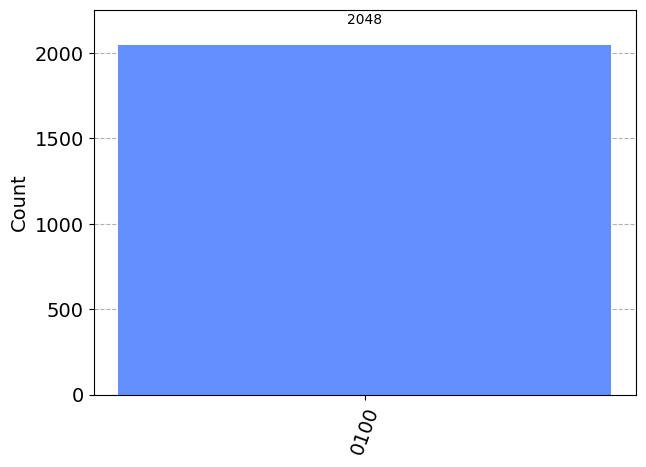

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_modsum = transpile(qc4, aer_sim)
results = aer_sim.run(t_modsum, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)